# A Snakemake-based Pipeline for RNA-seq Analysis

---
### Overview

Topical application of exogenous sequence-specific dsRNA can induce RNA interference in plants to provide protection against pathogens and insects. However, the processing of topically applied dsRNA and its systemic movement within the plant still remain unclear.

An automated Snakemake-based bioinformatics workflow for bulk RNA-seq data analysis is developed with two major tasks: (1) profile the presence of topical-applied CMV2b-dsRNA in phloem to investigate its systemic movement; (2) identify differential-expressed genes in cucumber plants caused by exogenous dsRNA to examine off-target effects of topical dsRNA application.

---
### Outline

1. `Trim Galore` perfroms quality trimming and removes detected adapter sequences.
2. `Salmon` builds the index of cucumber reference transcriptome, and then estimates transcript-level abundance from trimmed RNA-seq data.
3. `Tximport` Bioconductor package imports Salmon’s transcript-level quantifications for gene-level differential expression analysis
4. `DESeq2` Bioconductor package computes gene-level differential expression.
5. Python graphing library `Matplotlib` visualizes the read coverage across CMV2b reference sequence.

---
The python script below keeps the first isoform for each gene in cucumber reference transcriptome

In [68]:
%%writefile keep_first_isoform.py

from __future__ import print_function
import sys

def parse_fasta(data):
    name, seq = None, []
    for line in data:
        line = line.rstrip()
        if line.startswith('>'):
            if name:
                yield (name, ''.join(seq))
            name, seq = line, []
        else:
            seq.append(line)
    if name:
        yield (name, ''.join(seq))

isoforms = dict()
for defline, sequence in parse_fasta(sys.stdin):
    geneid = defline.split('(')[-1].split(')')[0]
    if geneid in isoforms:
        continue
    else:
        isoforms[geneid] = (defline, sequence)

for defline, sequence in isoforms.values():
    print(defline, sequence, sep='\n')

Writing keep_first_isoform.py


---
The following workflow.py documents the whole procedure of our Snakemake pipeline. Here, we use artificial RNA-seq data simulated by `Polyester` Bioconductor package to validate the utility of this workflow.

In [67]:
%%writefile workflow.py

sample_ids, replicate_ids = glob_wildcards("reads_raw/{sample}_{rep}.fasta.gz")

rule all:
    input:
        expand("trimmed/{sample}__{rep}_trimmed.fq.gz", sample=SAMPLES, rep=REPLICATES),
        expand("coverage/sense_{sample}_{rep}.txt", sample = sample_ids, rep = replicate_ids),
        expand("coverage/antisense_{sample}_{rep}.txt", sample = sample_ids, rep = replicate_ids),
        expand("cucumber_reference_transcriptome.fasta"),
        expand("transcripts_index"),
        expand("salmon/{sample}_{rep}_quant", sample = sample_ids, rep = replicate_ids)

        
rule trimming:    #TrimGalore
    input:
        "raw/{sample}_{rep}.fastq"
    output:
        "trimmed/{sample}_{rep}_trimmed.fq.gz"
    shell:
        """
        trim_galore -q 20 -j 4 \
         --stringency 3 {input} -o trimmed
        """

rule index_2b:    #Bowtie
    input:
        "2b_sequence.fa"
    params:
        basename = "2b_index"
    output:
        touch("index.done")
    shell:
        "bowtie-build {input} {params.basename}"


rule alignment_2b:    #Bowtie
    input:
        "index.done",
        "trimmed/{sample}_{rep}_trimmed.fq.gz"
    output:
        "map/{sample}_{rep}.sam"
    shell:
        "bowtie 2b_index -f {input[1]} -p 4 -S {output}"

        
rule get_coverage:    #SamTools
    input:
        "map/{sample}_{rep}.sam"
    output:
        "coverage/sense_{sample}_{rep}.txt",
        "coverage/antisense_{sample}_{rep}.txt"
    shell:
        """
        samtools view -h -F4 -F16 {input[0]} | samtools sort | samtools depth -a /dev/stdin > {output[0]}
        samtools view -h -F4 -f16 {input[0]} | samtools sort | samtools depth -a /dev/stdin > {output[1]}
        """

rule first_isoform:
    input:
        "GCF_000004075.2_ASM407v2_rna.fasta"
    output:
        "cucumber_reference_transcriptome.fasta"
    shell:
        "python keep_first_isoform.py < {input} > {output}"


rule indexing:    #Salmon
    input:
        "cucumber_reference_transcriptome.fasta"
    output:
        directory("transcripts_index")
    shell: 
        "salmon index -t {input} -i {output} -k 31"        


rule quantifying:    #Salmon
    input: 
        "transcripts_index",
        "trimmed/{sample}_{rep}_trimmed.fq.gz"
    output:
        directory("salmon/{sample}_{rep}_quant")
    shell:
        "salmon quant -i {input[0]} -l SF -r {input[1]} --validateMappings -o {output}"

        
rule DESeq2:
    input:
        expand("salmon/{sample}_{rep}_quant", sample = sample_ids, rep = replicate_ids)
    output:
        "control_vs_sprayed_petiole.csv"    
    shell:
        "Rscript deseq.R"

Writing workflow.py


---
The pipeline can be executed using the following command.

In [2]:
!snakemake -s workflow.py -j 4

Building DAG of jobs...
Using shell: /bin/bash
Provided cores: 4
Rules claiming more threads will be scaled down.
Job counts:
	count	jobs
	1	all
	1	first_isoform
	1	indexing
	9	quantifying
	12

[Tue Jun  4 08:34:56 2019]
rule first_isoform:
    input: GCF_000004075.2_ASM407v2_rna.fasta
    output: cucumber_reference_transcriptome.fasta
    jobid: 1

[Tue Jun  4 08:34:57 2019]
Finished job 1.
1 of 12 steps (8%) done

[Tue Jun  4 08:34:57 2019]
rule indexing:
    input: cucumber_reference_transcriptome.fasta
    output: transcripts_index
    jobid: 2

Version Info: ### PLEASE UPGRADE SALMON ###
### A newer version of salmon with important bug fixes and improvements is available. ####
###
The newest version, available at https://github.com/COMBINE-lab/salmon/releases
contains new features, improvements, and bug fixes; please upgrade at your
earliest convenience.
###
Sign up for the salmon mailing list to hear about new versions, features and updates at:
https://oceangenomics.com/subscribe

[2019-06-04 08:35:31.415] [jointLog] [info] Loading Quasi index
[2019-06-04 08:35:31.415] [jointLog] [info] Loading 32-bit quasi index
[2019-06-04 08:35:31.414] [stderrLog] [info] Loading Suffix Array 
[2019-06-04 08:35:31.416] [stderrLog] [info] Loading Suffix Array 
[2019-06-04 08:35:31.412] [jointLog] [info] Loading Quasi index
[2019-06-04 08:35:31.413] [jointLog] [info] Loading 32-bit quasi index
[2019-06-04 08:35:31.424] [jointLog] [info] Loading Quasi index
[2019-06-04 08:35:31.425] [jointLog] [info] Loading 32-bit quasi index
[2019-06-04 08:35:31.431] [stderrLog] [info] Loading Suffix Array 
[2019-06-04 08:35:31.434] [jointLog] [info] Loading Quasi index
[2019-06-04 08:35:31.434] [jointLog] [info] Loading 32-bit quasi index
[2019-06-04 08:35:31.461] [stderrLog] [info] Loading Suffix Array 
[2019-06-04 08:35:32.515] [stderrLog] [info] Loading Transcript Info 
[2019-06-04 08:35:32.515] [stderrLog] [info] Loading Transcript Info 
[2019-06-04 08:35:32.515] [stderrLog] [info] Loading

[2019-06-04 08:36:23.165] [jointLog] [info] Marked 0 weighted equivalence classes as degenerate
[2019-06-04 08:36:23.177] [jointLog] [info] iteration = 0 | max rel diff. = 2.35546




[2019-06-04 08:36:23.226] [jointLog] [info] Computed 22,278 rich equivalence classes for further processing
[2019-06-04 08:36:23.226] [jointLog] [info] Counted 5,533,635 total reads in the equivalence classes 
[2019-06-04 08:36:23.227] [jointLog] [info] Thread saw mini-batch with a maximum of 0.16% zero probability fragments




[2019-06-04 08:36:23.254] [jointLog] [info] Number of mappings discarded because of alignment score : 5,820
[2019-06-04 08:36:23.254] [jointLog] [info] Number of fragments entirely discarded because of alignment score : 375,620
[2019-06-04 08:36:23.254] [jointLog] [info] Number of fragments discarded because they have only dovetail (discordant) mappings : 0
[2019-06-04 08:36:23.254] [jointLog] [info] Mapping rate = 93.6432%

[2019-06-04 08:36:23.254] [jointLog] [info] finished qua

[2019-06-04 08:36:26.279] [jointLog] [info] Fragment incompatibility prior below threshold.  Incompatible fragments will be ignored.
[2019-06-04 08:36:26.279] [jointLog] [info] Usage of --validateMappings implies use of minScoreFraction. Since not explicitly specified, it is being set to 0.65
[2019-06-04 08:36:26.279] [jointLog] [info] Usage of --validateMappings, without --hardFilter implies use of range factorization. rangeFactorizationBins is being set to 4
[2019-06-04 08:36:26.279] [jointLog] [info] Usage of --validateMappings implies a default consensus slack of 0.2. Setting consensusSlack to 0.2.
[2019-06-04 08:36:26.279] [jointLog] [info] parsing read library format
[2019-06-04 08:36:26.279] [jointLog] [info] There is 1 library.
[2019-06-04 08:36:26.283] [jointLog] [info] Fragment incompatibility prior below threshold.  Incompatible fragments will be ignored.
[2019-06-04 08:36:26.283] [jointLog] [info] Usage of --validateMappings implies use of minScoreFraction. Since not explic

[Tue Jun  4 08:37:22 2019]
Finished job 9.
7 of 12 steps (58%) done
[Tue Jun  4 08:37:22 2019]
Finished job 10.
8 of 12 steps (67%) done

[Tue Jun  4 08:37:22 2019]
rule quantifying:
    input: transcripts_index, simulated_reads/sample_02.fasta.gz
    output: salmon/sample_02_quant
    jobid: 7
    wildcards: sample=sample, rep=02

[Tue Jun  4 08:37:22 2019]
Finished job 11.
9 of 12 steps (75%) done
[Tue Jun  4 08:37:22 2019]
Finished job 8.
10 of 12 steps (83%) done
Version Info: ### PLEASE UPGRADE SALMON ###
### A newer version of salmon with important bug fixes and improvements is available. ####
###
The newest version, available at https://github.com/COMBINE-lab/salmon/releases
contains new features, improvements, and bug fixes; please upgrade at your
earliest convenience.
###
Sign up for the salmon mailing list to hear about new versions, features and updates at:
https://oceangenomics.com/subscribe
###
### salmon (mapping-based) v0.13.1
### [ program ] => salmon 
### [ command ] =

---
The python script below will merge three replicates of samtools depth output files into single files for each group, and calculate mean and standard error within replicates.

In [16]:
import pandas as pd
import numpy as np
from scipy import stats

for i in ["sense","antisense"]:
    for j in ["sprayed","unsprayed"]:
        rep1 = pd.read_csv(i + '_' + j + '_rep1.txt', sep='\t', header=None)
        rep2 = pd.read_csv(i + '_' + j + '_rep2.txt', sep='\t', header=None)
        rep3 = pd.read_csv(i + '_' + j + '_rep3.txt', sep='\t', header=None)
        depth = pd.concat([rep1, rep2.iloc[:,-1], rep3.iloc[:,-1]],axis = 1)
        depth.columns = ["Ref","pos","rep1","rep2","rep3"]
        coverage = depth.loc[:,"rep1":"rep3"]
        mean = np.mean(coverage, axis=1)
        se = stats.sem(coverage, axis=1)
        depth['mean'] = mean
        depth['se'] = se
        depth.to_csv(i + '_' + j + '_coverage.txt', sep='\t', index=False)

---
The python script below will plot per base covergae against CMV2b sequence. Here an example plot is generated from artificial data, in which y-axis shows per base coverage of mapped reads and x-axis represents nucleotide position of CMV2b reference sequence. Sense- strand reads are plotted above the x-axis, while those mapped to the antisense strand are shown below the x-axis. The shading region displays biological variability as mean +/- standard error. Such profile plot can provide a clear illustration for the presence of CMV2b-dsRNA in phloem.

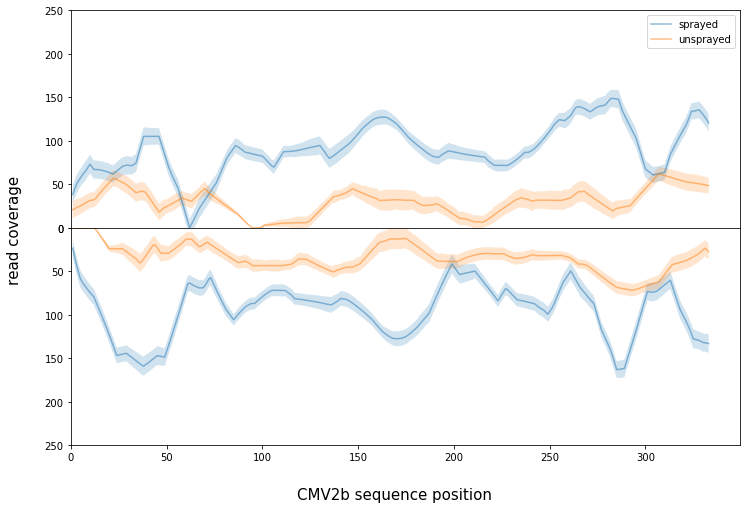

In [66]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

#this function takes an array of numbers and smoothes them out.
def sliding_window(data_array, window=12):
    data_array = np.array(data_array)
    new_list = []
    for i in range(len(data_array)):
        indices = range(max(i - window + 1, 0),
                        min(i + window + 1, len(data_array)))
        avg = 0
        for j in indices:
            avg += data_array[j]
        avg /= float(len(indices))
        new_list.append(avg)
 
    return np.array(new_list)


fig = plt.figure(figsize=(12,8))
ax1=plt.subplot(211)
for a in ["sprayed","unsprayed"]:
    sense = pd.read_csv('sense_' + a +'_coverage.txt', sep='\t')
    sense_mean = sliding_window(sense["mean"])
    sense_se = sliding_window(sense["se"])
    ax1.plot(sense["pos"],sense_mean, label=a, alpha=.5)
    ax1.fill_between(sense["pos"],sense_mean-sense_se,sense_mean+sense_se,alpha=.2)
    ax1.set_xlim(left=0)
    ax1.set_ylim(bottom=0)
    ax1.set_ylim([0,250])
    plt.setp(ax1.get_xticklabels(),visible=False)
    ax1.legend(loc='upper right')
    
ax2=plt.subplot(212)
ax2.invert_yaxis()
for b in ["sprayed","unsprayed"]:
    antisense = pd.read_csv('antisense_' + b + '_coverage.txt', sep='\t')
    antisense_mean = sliding_window(antisense["mean"])
    antisense_se = sliding_window(antisense["se"])
    ax2.plot(antisense["pos"],antisense_mean, alpha=.5)
    ax2.fill_between(antisense["pos"],antisense_mean-antisense_se,antisense_mean+antisense_se,alpha=.2)
    ax2.set_xlim(left=0)
    ax2.set_ylim(top=0)
    ax2.set_ylim([250,0])
    plt.subplots_adjust(hspace=0)
    
    
fig.text(0.5, 0.04, 'CMV2b sequence position', ha='center', va='center', fontsize=15)
fig.text(0.06, 0.5, 'read coverage', ha='center', va='center', rotation='vertical', fontsize=15)

plt.savefig('coverage.png')